Purpose: Calculate log fold change for the mean TPM of all stress samples vs. all control samples for each experiment. Threshold to be considered "differentially expressed": less than 0.5 or greater than 2. Compare the numbers of "DEGs" shared and unique between experiments within each stressor, and between stressors.<br>
Author: Anna Pardo<br>
Date initiated: July 13, 2023

In [1]:
import numpy as np
import pandas as pd
from venn import venn
import matplotlib.pyplot as plt
import math

In [2]:
# load TPM data
tpm = pd.read_csv("../data/rawtpm_bptreat_noPEG.tsv",sep="\t",header="infer")
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.171184,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.108052,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.178304,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959


In [3]:
# replace DroughtRepeat with Drought
tpm["Treatment"].mask(tpm["Treatment"]=="DroughtRepeat","Drought",inplace=True)

In [4]:
# find BioProjects containing more than two treatments
bpg = []
for b in tpm["BioProject"].unique():
    df = tpm[tpm["BioProject"]==b]
    if len(df["Treatment"].unique())>2:
        bpg.append(b)
bpg

['PRJNA244661', 'PRJNA747925', 'PRJNA290180', 'PRJNA689935']

In [5]:
# code development section
## pull out a single BioProject
sbp = tpm[tpm["BioProject"]=="PRJNA244661"]
len(sbp.index)

30

In [6]:
sbp.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
86,SRR1685963,PRJNA244661,Cold,11.016258,5.777481,0.000000,5.182289,6.386443,22.262804,0.535458,...,0.0,0.565755,0.0,0.0,0.574932,0.0,0.0,0.0,0.0,0.000000
87,SRR1819625,PRJNA244661,Cold,11.960183,6.090775,0.334902,2.161815,3.873458,17.580838,0.657928,...,0.0,0.540465,0.0,0.0,0.581866,0.0,0.0,0.0,0.0,0.505476
88,SRR1819627,PRJNA244661,Cold,12.091675,7.193755,0.187254,3.272134,4.661307,22.781034,0.966604,...,0.0,0.568207,0.0,0.0,0.446233,0.0,0.0,0.0,0.0,0.000000
89,SRR1819630,PRJNA244661,Control,17.874888,4.862732,0.118342,7.734795,7.770351,21.690569,0.194113,...,0.0,0.403297,0.0,0.0,1.106992,0.0,0.0,0.0,0.0,0.000000
90,SRR1685964,PRJNA244661,Control,17.218346,4.579571,0.207559,7.374963,12.297897,21.731852,0.244228,...,0.0,0.300867,0.0,0.0,0.603153,0.0,0.0,0.0,0.0,0.000000


In [7]:
# set Sample as index, drop BioProject
sbp = sbp.set_index("Sample").drop("BioProject",axis=1)
sbp.head()

,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,Zm00001eb000110,Zm00001eb000120,...,Zm00001eb442810,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030
Sample,,,,,,,,,,,,,,,,,,,,,
SRR1685963,Cold,11.016258,5.777481,0.000000,5.182289,6.386443,22.262804,0.535458,0.0,1.269572,...,0.0,0.565755,0.0,0.0,0.574932,0.0,0.0,0.0,0.0,0.000000
SRR1819625,Cold,11.960183,6.090775,0.334902,2.161815,3.873458,17.580838,0.657928,0.0,1.101511,...,0.0,0.540465,0.0,0.0,0.581866,0.0,0.0,0.0,0.0,0.505476
SRR1819627,Cold,12.091675,7.193755,0.187254,3.272134,4.661307,22.781034,0.966604,0.0,0.646767,...,0.0,0.568207,0.0,0.0,0.446233,0.0,0.0,0.0,0.0,0.000000
SRR1819630,Control,17.874888,4.862732,0.118342,7.734795,7.770351,21.690569,0.194113,0.0,1.712663,...,0.0,0.403297,0.0,0.0,1.106992,0.0,0.0,0.0,0.0,0.000000
SRR1685964,Control,17.218346,4.579571,0.207559,7.374963,12.297897,21.731852,0.244228,0.0,4.062457,...,0.0,0.300867,0.0,0.0,0.603153,0.0,0.0,0.0,0.0,0.000000


In [8]:
# take mean TPM for each gene by Treatment
means = sbp.groupby("Treatment").mean().transpose()

In [5]:
# make a function for calculating TN-ratio (https://www.biorxiv.org/content/10.1101/2023.04.17.537107v2.full)
def tn_ratio(stress_tpm,control_tpm):
    return (stress_tpm+1)/(control_tpm+1)

In [10]:
means.head()

Treatment,Cold,Control,Heat,Salt
Zm00001eb000010,10.196802,15.329133,7.045003,18.058334
Zm00001eb000020,12.306907,12.943065,7.334554,5.937275
Zm00001eb000050,0.337335,0.127397,0.056613,0.172569
Zm00001eb000060,22.519291,29.997633,8.737129,27.129418
Zm00001eb000070,3.155247,5.516393,5.321580,7.507933


In [11]:
# go through the stressor columns and calculate TN ratio
for i in means.columns:
    if i != "Control":
        means[i+"_TN"] = tn_ratio(means[i],means["Control"])

In [12]:
means.head()

Treatment,Cold,Control,Heat,Salt,Cold_TN,Heat_TN,Salt_TN
Zm00001eb000010,10.196802,15.329133,7.045003,18.058334,0.685695,0.492678,1.167137
Zm00001eb000020,12.306907,12.943065,7.334554,5.937275,0.954375,0.597756,0.497543
Zm00001eb000050,0.337335,0.127397,0.056613,0.172569,1.186214,0.937214,1.040068
Zm00001eb000060,22.519291,29.997633,8.737129,27.129418,0.758745,0.314125,0.907470
Zm00001eb000070,3.155247,5.516393,5.321580,7.507933,0.637661,0.970104,1.305620


In [13]:
means.reset_index().head()

Treatment,index,Cold,Control,Heat,Salt,Cold_TN,Heat_TN,Salt_TN
0,Zm00001eb000010,10.196802,15.329133,7.045003,18.058334,0.685695,0.492678,1.167137
1,Zm00001eb000020,12.306907,12.943065,7.334554,5.937275,0.954375,0.597756,0.497543
2,Zm00001eb000050,0.337335,0.127397,0.056613,0.172569,1.186214,0.937214,1.040068
3,Zm00001eb000060,22.519291,29.997633,8.737129,27.129418,0.758745,0.314125,0.907470
4,Zm00001eb000070,3.155247,5.516393,5.321580,7.507933,0.637661,0.970104,1.305620


In [6]:
# write a function that will do all that for a given experiment
def experiment_tn(bioproject,tpmdf):
    sbp = tpmdf[tpmdf["BioProject"]==bioproject]
    sbp = sbp.set_index("Sample").drop("BioProject",axis=1)
    means = sbp.groupby("Treatment").mean().transpose()
    for i in means.columns:
        if i != "Control":
            means[i+"_TN"] = tn_ratio(means[i],means["Control"])
    return means

In [7]:
# make the calculation for all the experiments and output a dictionary of dataframes
dfdict = {}
for b in tpm["BioProject"].unique():
    dfdict[b] = experiment_tn(b,tpm)

In [8]:
dfdict

{'PRJNA637522': Treatment         Control    Drought  Drought_TN
 Zm00001eb000010  9.746302  11.877533    1.198322
 Zm00001eb000020  2.480653   3.499408    1.292691
 Zm00001eb000050  0.136863   0.206377    1.061146
 Zm00001eb000060  8.068743  10.158890    1.230478
 Zm00001eb000070  3.962157   5.259550    1.261458
 ...                   ...        ...         ...
 Zm00001eb442890  4.685778   5.683330    1.175447
 Zm00001eb442910  0.000000   0.016156    1.016156
 Zm00001eb442960  0.074790   0.069900    0.995450
 Zm00001eb442980  0.002696   0.000580    0.997890
 Zm00001eb443030  1.164656   1.312994    1.068527
 
 [39004 rows x 3 columns],
 'PRJNA506720': Treatment          Control       Heat   Heat_TN
 Zm00001eb000010  12.340457  21.456264  1.683321
 Zm00001eb000020   0.887969   3.223832  2.237236
 Zm00001eb000050   0.452641   0.035022  0.712511
 Zm00001eb000060  12.710808  23.183188  1.763805
 Zm00001eb000070   0.045260   0.044177  0.998964
 ...                    ...        ...       ..

In [13]:
# work done on 8/23/2023
## save each df in dfdict to a tsv file in a directory
directory = "../data/tn_by_experiment_dfs/"

In [16]:
for k in dfdict.keys():
    # pull out the dataframe
    df = dfdict[k]
    # add a BioProject column
    df["BioProject"] = k
    # reset the index
    df = df.reset_index().rename(columns={"index":"GeneID"})
    # save the dataframe
    df.to_csv(directory+k+".tsv",sep="\t",header=True,index=False)

In [16]:
# goal: make Venn diagrams on a per-stressor basis
# go through all the dictionary entries and make dictionaries for each stressor
cold = {}
ln = {}
heat = {}
drought = {}
flood = {}
salt = {}

for b in dfdict.keys():
    df = dfdict[b]
    if "Cold" in df.columns:
        cold[b] = df
    if "Low_Nitrogen" in df.columns:
        ln[b] = df
    if "Heat" in df.columns:
        heat[b] = df
    if "Drought" in df.columns:
        drought[b] = df
    if "Flooding" in df.columns:
        flood[b] = df
    if "Salt" in df.columns:
        salt[b] = df

In [17]:
# next item of business: pull out the number of "DEGs" for each BioProject in each stress dictionary
## make a list of the stress dictionaries
sd = [cold,ln,heat,drought,flood,salt]

In [18]:
# make stressor list in same order as dictionaries in sd
stressors = ["Cold","Low_Nitrogen","Heat","Drought","Flooding","Salt"]

In [19]:
upgenes = {}
downgenes = {}
for i in range(len(stressors)):
    s = stressors[i]
    d = sd[i]
    upgenes[s] = {}
    downgenes[s] = {}
    for k in d.keys():
        df = d[k]
        # subset dataframe to only the genes that have TN-ratio <0.5 or >2
        down = df[df[s+"_TN"]<0.5].reset_index().rename(columns={"index":"GeneID"})
        up = df[df[s+"_TN"]>2].reset_index().rename(columns={"index":"GeneID"})
        upgenes[s][k] = set(up["GeneID"])
        downgenes[s][k] = set(down["GeneID"])

<AxesSubplot: >

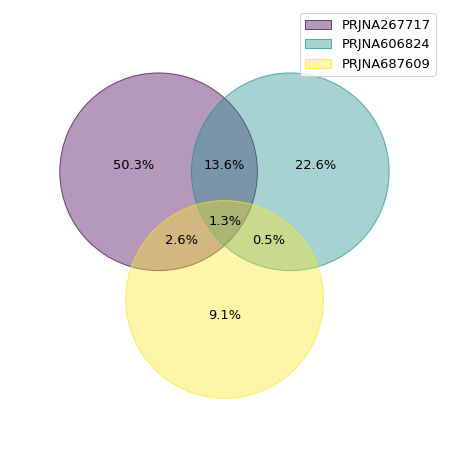

In [20]:
# make Venn diagram for cold upregulated
venn(upgenes["Flooding"],fmt="{percentage:.1f}%")

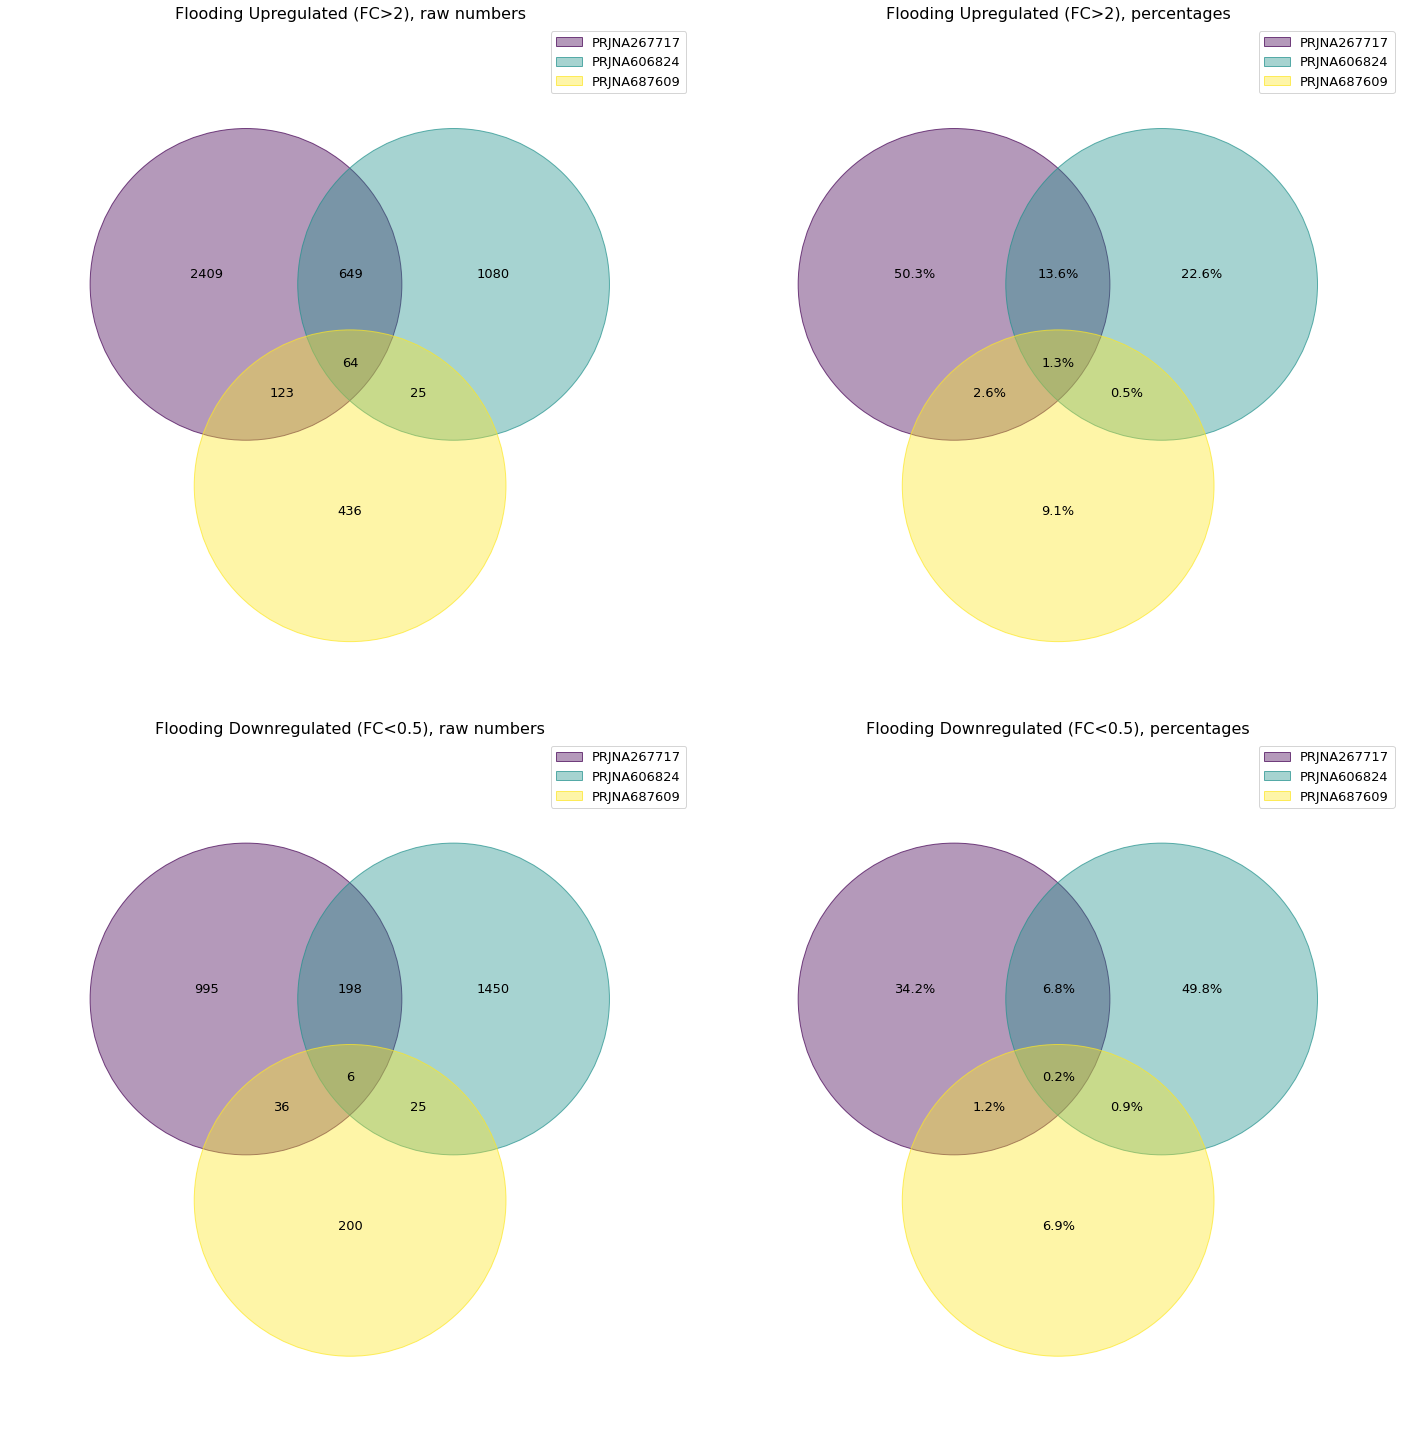

In [21]:
# see if I can generate a 4-panel plot for flooding showing Venn diagrams with raw numbers
## and percentages for upregulated & downregulated
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

a = venn(upgenes["Flooding"],ax=ax[0,0])
a.set_title("Flooding Upregulated (FC>2), raw numbers",fontsize=16)

b = venn(upgenes["Flooding"],fmt="{percentage:.1f}%",ax=ax[0,1])
b.set_title("Flooding Upregulated (FC>2), percentages",fontsize=16)

c = venn(downgenes["Flooding"],ax=ax[1,0])
c.set_title("Flooding Downregulated (FC<0.5), raw numbers",fontsize=16)

d = venn(downgenes["Flooding"],fmt="{percentage:.1f}%",ax=ax[1,1])
d.set_title("Flooding Downregulated (FC<0.5), percentages",fontsize=16)

plt.tight_layout()
plt.savefig("../figures/fc_venn_flooding_bioprojects.pdf")

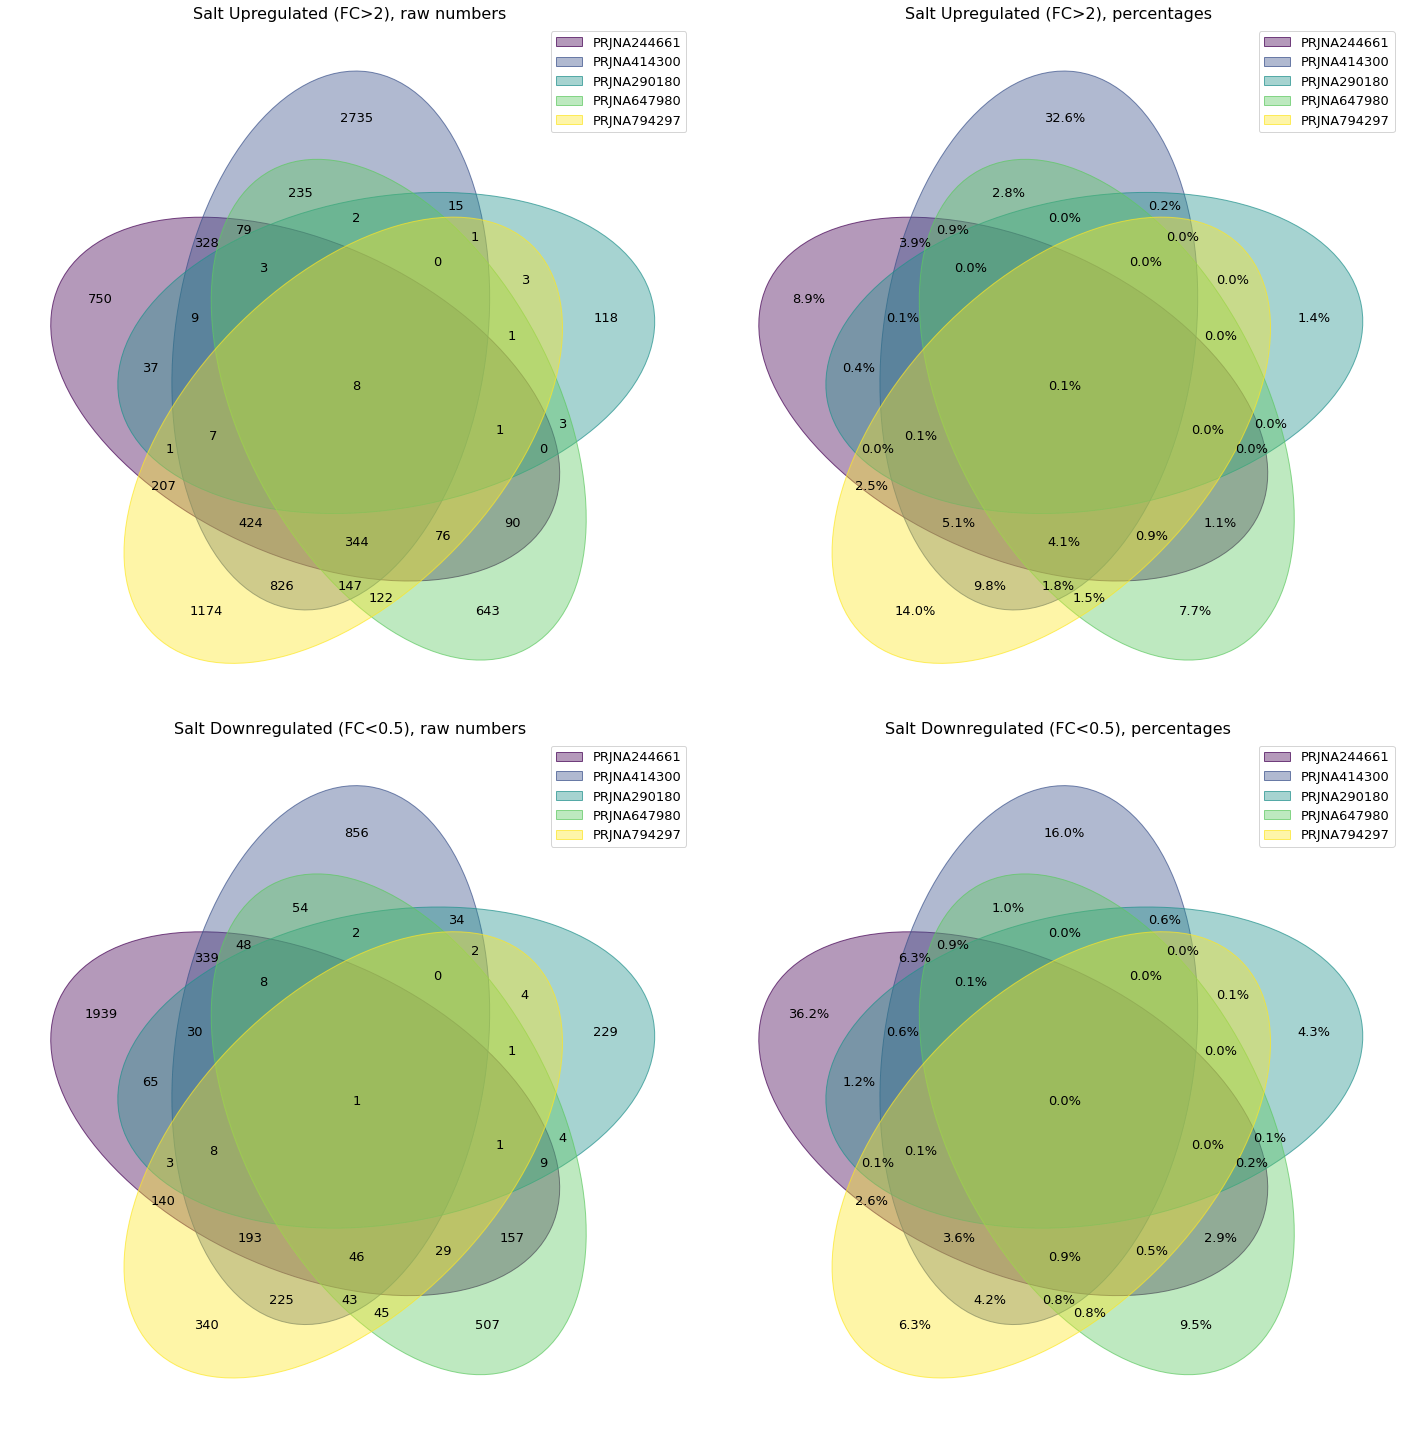

In [22]:
# do the same for salt
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

a = venn(upgenes["Salt"],ax=ax[0,0])
a.set_title("Salt Upregulated (FC>2), raw numbers",fontsize=16)

b = venn(upgenes["Salt"],fmt="{percentage:.1f}%",ax=ax[0,1])
b.set_title("Salt Upregulated (FC>2), percentages",fontsize=16)

c = venn(downgenes["Salt"],ax=ax[1,0])
c.set_title("Salt Downregulated (FC<0.5), raw numbers",fontsize=16)

d = venn(downgenes["Salt"],fmt="{percentage:.1f}%",ax=ax[1,1])
d.set_title("Salt Downregulated (FC<0.5), percentages",fontsize=16)

plt.tight_layout()
plt.savefig("../figures/fc_venn_salt_bioprojects.pdf")

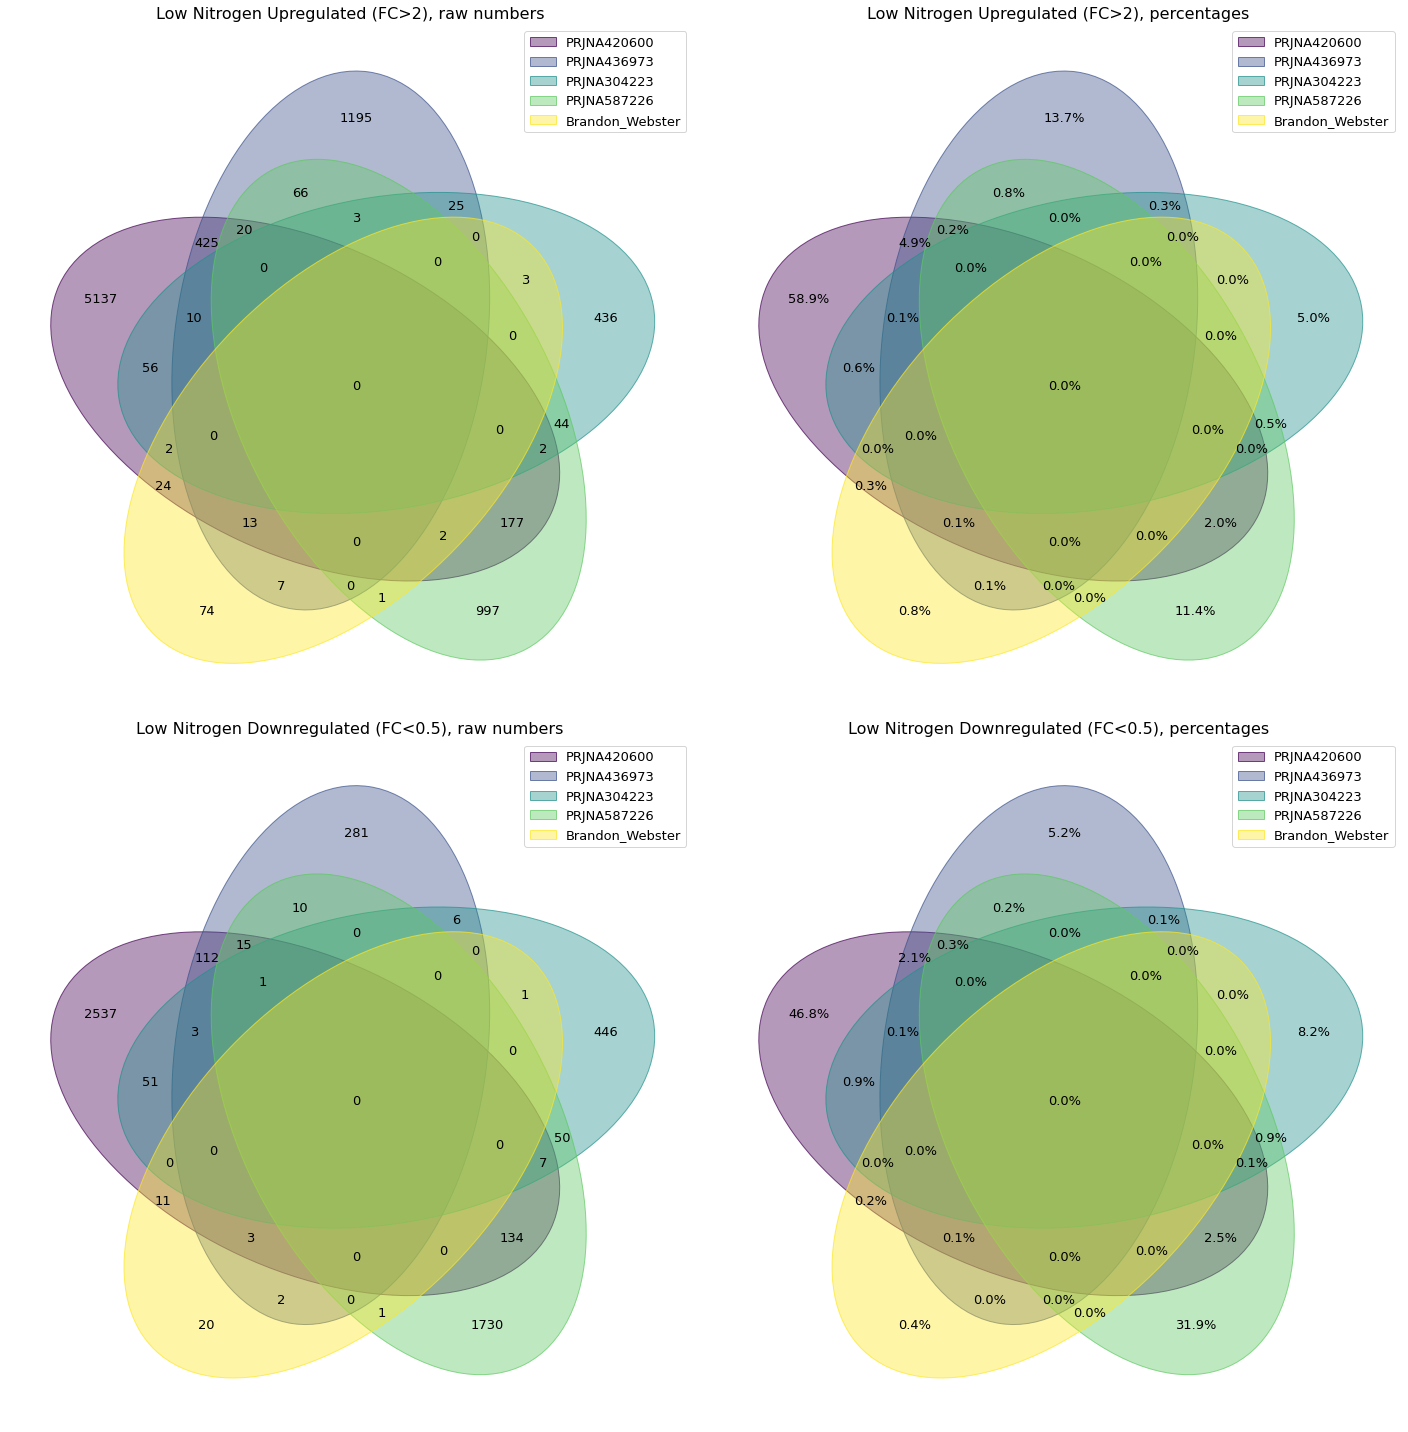

In [23]:
# and for low nitrogen
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

a = venn(upgenes["Low_Nitrogen"],ax=ax[0,0])
a.set_title("Low Nitrogen Upregulated (FC>2), raw numbers",fontsize=16)

b = venn(upgenes["Low_Nitrogen"],fmt="{percentage:.1f}%",ax=ax[0,1])
b.set_title("Low Nitrogen Upregulated (FC>2), percentages",fontsize=16)

c = venn(downgenes["Low_Nitrogen"],ax=ax[1,0])
c.set_title("Low Nitrogen Downregulated (FC<0.5), raw numbers",fontsize=16)

d = venn(downgenes["Low_Nitrogen"],fmt="{percentage:.1f}%",ax=ax[1,1])
d.set_title("Low Nitrogen Downregulated (FC<0.5), percentages",fontsize=16)

plt.tight_layout()
plt.savefig("../figures/fc_venn_low_N_bioprojects.pdf")

In [24]:
# load metadata
md = pd.read_csv("../data/srr_numbers_with_metadata_12-May-2023.csv",sep=",",header="infer")
md.columns

Index(['BioProject', 'Sample', 'sample_name', 'Replicate_num', 'Genotype',
       'Technology', 'Library_layout', 'Treatment', 'Duration_hours',
       'Time_after_treatment', 'Concentration_mM', 'Concentration',
       'Developmental_stage', 'Tissue', 'Day_length_hours', 'Day_temp_C',
       'Night_temp_C', 'Relative humidity (%)', 'Light (umol/m2/s)',
       'Growth Env.', 'Media', 'Notes'],
      dtype='object')

In [25]:
# subset md to the BioProjects in low N
mdln = md[md["BioProject"].isin(upgenes["Low_Nitrogen"].keys())][["BioProject","Sample","Tissue","Genotype","Treatment"]]
mdln.head()

,BioProject,Sample,Tissue,Genotype,Treatment
401,PRJNA420600,SRR6335599,Leaf,B73,Control
402,PRJNA420600,SRR6335600,Leaf,B73,Control
403,PRJNA420600,SRR6335601,Leaf,B73,Control
404,PRJNA420600,SRR6335602,Leaf,B73,Control
405,PRJNA420600,SRR6335603,Leaf,B73,Control


In [26]:
mdln["Genotype"].unique()

array(['B73', 'B73XMO17', 'B73XPHN82', 'B73XPHZ51', 'LH195XPHN82',
       'PHB47XPHN82'], dtype=object)

In [27]:
mdln["Tissue"].unique()

array(['Leaf', 'Root'], dtype=object)

In [28]:
# for each tissue and genotype, how many different BioProjects are there?
for i in mdln["Tissue"].unique():
    print(i)
    df = mdln[mdln["Tissue"]==i]
    print(len(df["BioProject"].unique()))

Leaf
3
Root
2


In [29]:
# for leaf tissue, for each genotype, how many BioProjects are there?
leafln = mdln[mdln["Tissue"]=="Leaf"]
for g in leafln["Genotype"].unique():
    print(g)
    df = leafln[leafln["Genotype"]==g]
    print(len(df["BioProject"].unique()))

B73
2
B73XMO17
1
B73XPHN82
1
B73XPHZ51
1
LH195XPHN82
1
PHB47XPHN82
1


In [30]:
# subset to leaf B73 and check out the Venn diagrams for this
leafb73ln = leafln[leafln["Genotype"]=="B73"]

In [31]:
leafb73ln.columns

Index(['BioProject', 'Sample', 'Tissue', 'Genotype', 'Treatment'], dtype='object')

In [32]:
tpm.columns

Index(['Sample', 'BioProject', 'Treatment', 'Zm00001eb000010',
       'Zm00001eb000020', 'Zm00001eb000050', 'Zm00001eb000060',
       'Zm00001eb000070', 'Zm00001eb000080', 'Zm00001eb000100',
       ...
       'Zm00001eb442810', 'Zm00001eb442820', 'Zm00001eb442840',
       'Zm00001eb442850', 'Zm00001eb442870', 'Zm00001eb442890',
       'Zm00001eb442910', 'Zm00001eb442960', 'Zm00001eb442980',
       'Zm00001eb443030'],
      dtype='object', length=39007)

In [33]:
# merge leafb73ln with tpm
leafb73lntpm = leafb73ln[["Sample"]].merge(tpm)

In [34]:
# calculate the log fold change, etc.
dfdict = {}
for b in leafb73lntpm["BioProject"].unique():
    dfdict[b] = experiment_tn(b,leafb73lntpm)

In [35]:
up = {}
down = {}
for k in dfdict.keys():
    df = dfdict[k]
    d = df[df["Low_Nitrogen_TN"]<0.5].reset_index().rename(columns={"index":"GeneID"})
    u = df[df["Low_Nitrogen_TN"]>2].reset_index().rename(columns={"index":"GeneID"})
    up[k] = set(u["GeneID"])
    down[k] = set(d["GeneID"])
up

{'PRJNA420600': {'Zm00001eb345740',
  'Zm00001eb183960',
  'Zm00001eb058230',
  'Zm00001eb118650',
  'Zm00001eb267290',
  'Zm00001eb003340',
  'Zm00001eb116960',
  'Zm00001eb415930',
  'Zm00001eb417400',
  'Zm00001eb386870',
  'Zm00001eb042100',
  'Zm00001eb302160',
  'Zm00001eb074770',
  'Zm00001eb212630',
  'Zm00001eb198100',
  'Zm00001eb007730',
  'Zm00001eb172230',
  'Zm00001eb157010',
  'Zm00001eb155950',
  'Zm00001eb335710',
  'Zm00001eb364280',
  'Zm00001eb095840',
  'Zm00001eb097890',
  'Zm00001eb146860',
  'Zm00001eb119210',
  'Zm00001eb293350',
  'Zm00001eb035630',
  'Zm00001eb410420',
  'Zm00001eb119410',
  'Zm00001eb279170',
  'Zm00001eb134130',
  'Zm00001eb091060',
  'Zm00001eb420460',
  'Zm00001eb346300',
  'Zm00001eb286070',
  'Zm00001eb124740',
  'Zm00001eb042220',
  'Zm00001eb220850',
  'Zm00001eb141330',
  'Zm00001eb059860',
  'Zm00001eb122060',
  'Zm00001eb421870',
  'Zm00001eb293340',
  'Zm00001eb399960',
  'Zm00001eb103800',
  'Zm00001eb169710',
  'Zm00001eb146250'

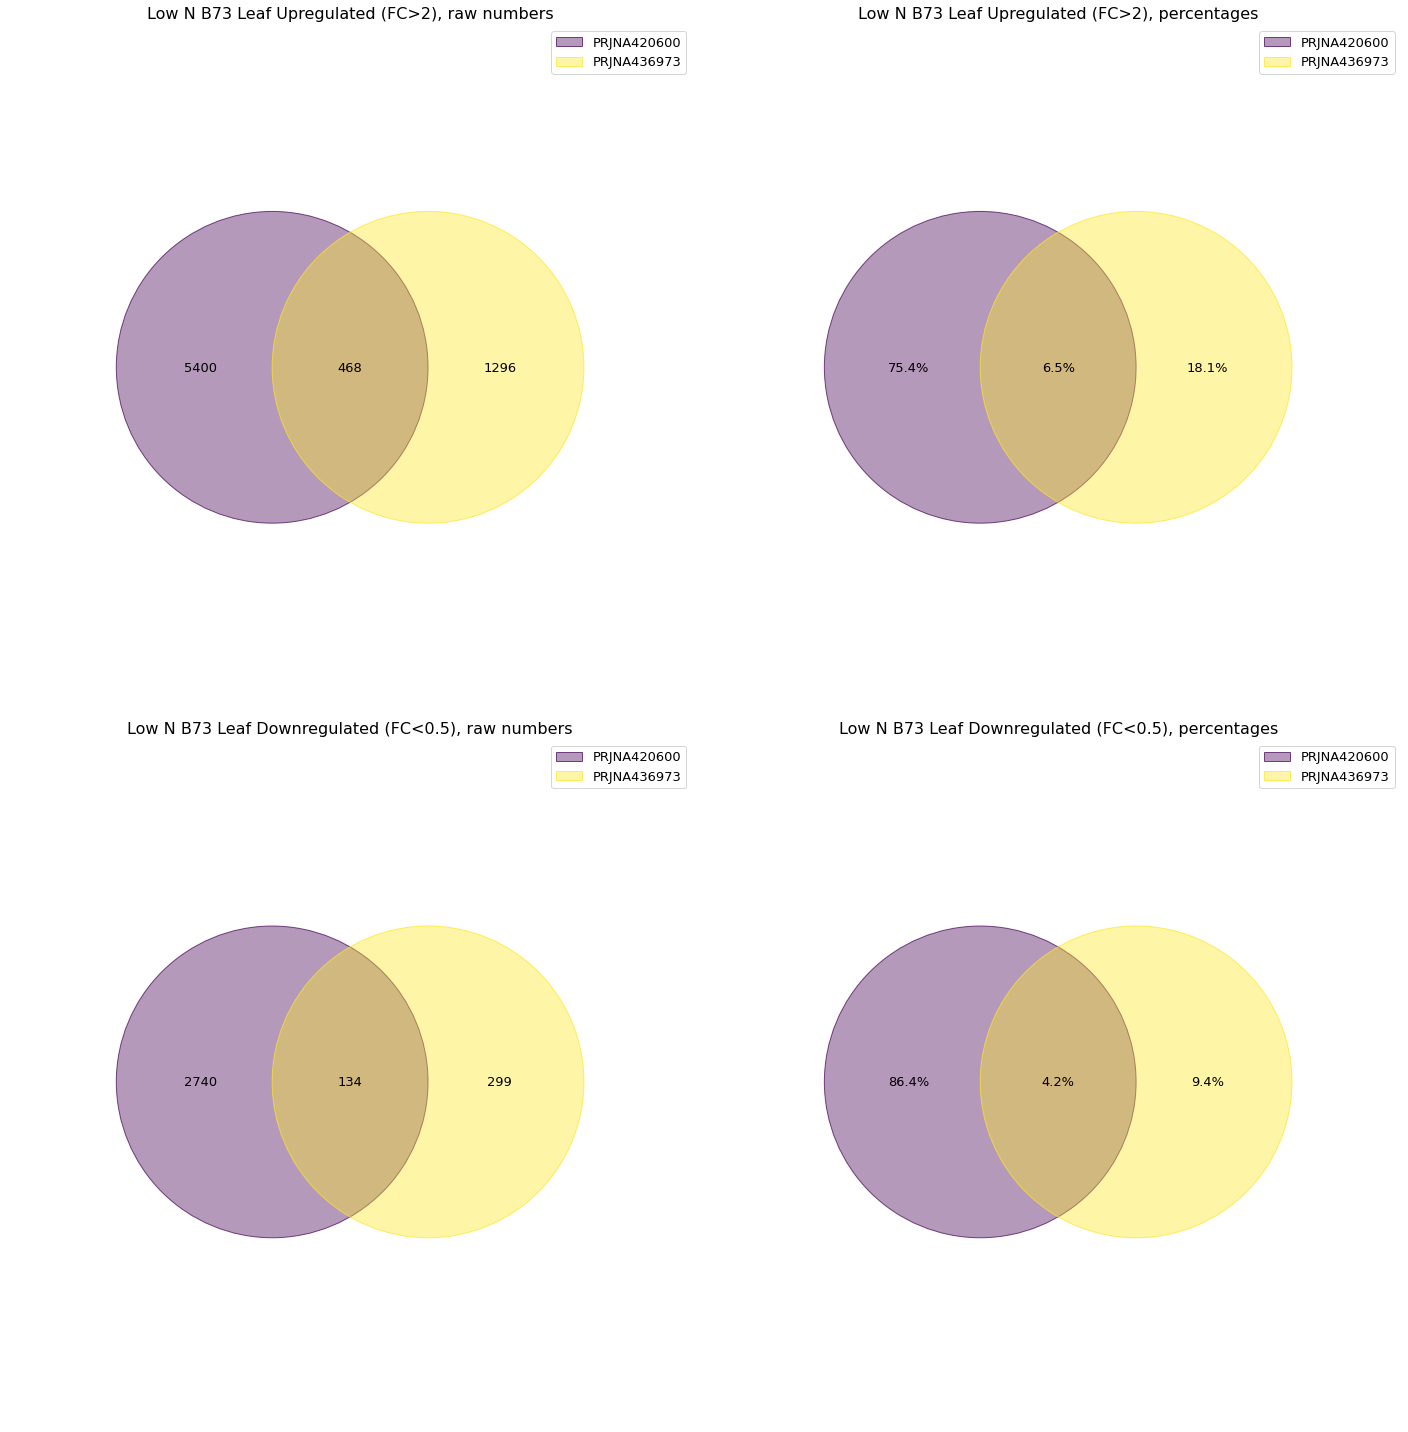

In [36]:
# make Venn diagrams as before
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(20,20))

a = venn(up,ax=ax[0,0])
a.set_title("Low N B73 Leaf Upregulated (FC>2), raw numbers",fontsize=16)

b = venn(up,fmt="{percentage:.1f}%",ax=ax[0,1])
b.set_title("Low N B73 Leaf Upregulated (FC>2), percentages",fontsize=16)

c = venn(down,ax=ax[1,0])
c.set_title("Low N B73 Leaf Downregulated (FC<0.5), raw numbers",fontsize=16)

d = venn(down,fmt="{percentage:.1f}%",ax=ax[1,1])
d.set_title("Low N B73 Leaf Downregulated (FC<0.5), percentages",fontsize=16)

plt.tight_layout()
plt.savefig("../figures/fc_venn_lowN_B73_leaf_bioprojects.pdf")

Drought, heat, & cold all have >5 BioProjects and are going to require a more complex figure plotting method: UpSet plots.

In [37]:
from upsetplot import generate_counts

In [38]:
example = generate_counts()
example

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

In [39]:
example = pd.DataFrame(example)

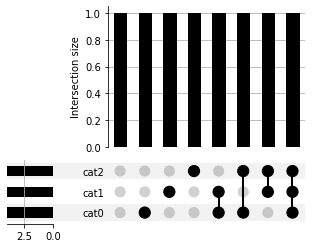

In [40]:
from upsetplot import plot
plot(example)
plt.show()

In [41]:
# set up data for an UpSet plot for cold upregulated genes
coldup = upgenes["Cold"]
coldup

{'PRJNA556806': {'Zm00001eb001970',
  'Zm00001eb009570',
  'Zm00001eb012040',
  'Zm00001eb027960',
  'Zm00001eb063670',
  'Zm00001eb068470',
  'Zm00001eb095110',
  'Zm00001eb116960',
  'Zm00001eb118720',
  'Zm00001eb118730',
  'Zm00001eb121190',
  'Zm00001eb168040',
  'Zm00001eb184470',
  'Zm00001eb206670',
  'Zm00001eb239380',
  'Zm00001eb247000',
  'Zm00001eb256260',
  'Zm00001eb275400',
  'Zm00001eb285770',
  'Zm00001eb327110',
  'Zm00001eb335560',
  'Zm00001eb339970',
  'Zm00001eb342740',
  'Zm00001eb356910',
  'Zm00001eb358800',
  'Zm00001eb366460',
  'Zm00001eb367650',
  'Zm00001eb367720',
  'Zm00001eb370870',
  'Zm00001eb384750',
  'Zm00001eb389190',
  'Zm00001eb399340'},
 'PRJNA244661': {'Zm00001eb071510',
  'Zm00001eb343740',
  'Zm00001eb435710',
  'Zm00001eb432950',
  'Zm00001eb423420',
  'Zm00001eb176600',
  'Zm00001eb395440',
  'Zm00001eb187220',
  'Zm00001eb269010',
  'Zm00001eb285460',
  'Zm00001eb116960',
  'Zm00001eb176850',
  'Zm00001eb066690',
  'Zm00001eb386870',
  '

July 17, 2023<br>
Instead of making UpSet plots, I'm going to follow what Jeremy did in https://www-pnas-org.proxy1.cl.msu.edu/doi/10.1073/pnas.2216894120 (Fig. 2B-C). However, instead of having the number of genotypes with differential expression on the X axis, I will put number of BioProjects with differential expression of a given gene. Then it will essentially be a manual histogram.

In [42]:
a = set([1,2,3,4])
b = set([1,3,5,7])
c = set([1,2,4,6])
d = set([1,3,7,12])

In [43]:
setlist = [a,b,c,d]

In [44]:
set.intersection(a,b,c,d)

{1}

In [45]:
sets = [
    set([1, 2, 3, 4]),
    set([1, 3, 5, 7]),
    set([1, 2, 4, 6]),
    set([1, 3, 7, 12])
]

In [46]:
num_sets = len(sets)
num_sets

4

In [47]:
common_to_all = set.intersection(*sets)
common_to_all

{1}

In [48]:
elements_count = {}
# Initialize count for each element
for element in common_to_all:
    elements_count[element] = num_sets - 1

In [49]:
elements_count

{1: 3}

In [50]:
# Find common elements for each subset of sets
for i in range(num_sets):
    for j in range(i + 1, num_sets):
        common_to_subset = sets[i].intersection(sets[j])
        for element in common_to_subset:
            if element not in elements_count:
                elements_count[element] = num_sets - 2
            else:
                elements_count[element] -= 1


In [51]:
# Count unique elements for each set
unique_count = {}
for i, s in enumerate(sets):
    for element in s:
        if element not in elements_count:
            unique_count[element] = 1
        else:
            if elements_count[element] != 0:
                elements_count[element] -= 1

In [52]:
# Count elements that are unique to one set
unique_to_one = sum(count == num_sets - 1 for count in unique_count.values())

In [53]:
# Count elements common to all sets
common_to_all_count = len(common_to_all)

In [54]:
# Count elements common to subsets of sets
common_to_subsets_count = sum(count == 0 for count in elements_count.values())

In [55]:
# Count elements common to two sets
common_to_two_count = num_sets * (num_sets - 1) // 2 - common_to_subsets_count

In [56]:
print("Elements common to all sets:", common_to_all_count)
print("Elements common to subsets of sets:", common_to_subsets_count)
print("Elements common to two sets:", common_to_two_count)
print("Elements unique to one set:", unique_to_one)

Elements common to all sets: 1
Elements common to subsets of sets: 4
Elements common to two sets: 2
Elements unique to one set: 0


In [57]:
elements_count

{1: -7, 3: 0, 2: 0, 4: 0, 7: 0}

In [58]:
unique_count

{5: 1, 6: 1, 12: 1}

In [59]:
def analyze_sets(sets):
    num_sets = len(sets)
    common_to_all = set.intersection(*sets)
    elements_count = {}

    # Initialize count for each element
    for element in common_to_all:
        elements_count[element] = num_sets - 1

    # Find common elements for each subset of sets
    for i in range(num_sets):
        for j in range(i + 1, num_sets):
            common_to_subset = sets[i].intersection(sets[j])
            for element in common_to_subset:
                if element not in elements_count:
                    elements_count[element] = num_sets - 2
                else:
                    elements_count[element] -= 1

    # Count unique elements for each set
    unique_count = {}
    for i, s in enumerate(sets):
        for element in s:
            if element not in elements_count:
                unique_count[element] = 1
            else:
                if elements_count[element] != 0:
                    elements_count[element] -= 1

    # Count elements that are unique to one set
    unique_to_one = sum(count == num_sets - 1 for count in unique_count.values())

    # Count elements common to all sets
    common_to_all_count = len(common_to_all)

    # Count elements common to subsets of specific sizes
    common_to_seven_count = sum(count == num_sets - 1 for count in elements_count.values())
    common_to_six_count = sum(count == num_sets - 2 for count in elements_count.values())
    common_to_five_count = sum(count == num_sets - 3 for count in elements_count.values())
    common_to_four_count = sum(count == num_sets - 4 for count in elements_count.values())
    common_to_three_count = sum(count == num_sets - 5 for count in elements_count.values())
    common_to_two_count = sum(count == num_sets - 6 for count in elements_count.values())

    # Return the analysis results as a dictionary
    analysis_results = {
        "Genes common to all sets": common_to_all_count,
        "Genes common to seven sets": common_to_seven_count,
        "Genes common to six sets": common_to_six_count,
        "Genes common to five sets": common_to_five_count,
        "Genes common to four sets": common_to_four_count,
        "Genes common to three sets": common_to_three_count,
        "Genes common to two sets": common_to_two_count,
        "Genes unique to one set": unique_to_one
    }

    return analysis_results


In [60]:
def analyze_15_sets(sets):
    num_sets = len(sets)
    common_to_all = set.intersection(*sets)
    elements_count = {}

    # Initialize count for each element
    for element in common_to_all:
        elements_count[element] = num_sets - 1

    # Find common elements for each subset of sets
    for i in range(num_sets):
        for j in range(i + 1, num_sets):
            common_to_subset = sets[i].intersection(sets[j])
            for element in common_to_subset:
                if element not in elements_count:
                    elements_count[element] = num_sets - 2
                else:
                    elements_count[element] -= 1

    # Count unique elements for each set
    unique_count = {}
    for i, s in enumerate(sets):
        for element in s:
            if element not in elements_count:
                unique_count[element] = 1
            else:
                if elements_count[element] != 0:
                    elements_count[element] -= 1

    # Count elements that are unique to one set
    unique_to_one = sum(count == num_sets - 1 for count in unique_count.values())

    # Count elements common to all sets
    common_to_all_count = len(common_to_all)

    # Count elements common to subsets of specific sizes
    common_to_fourteen_count = sum(count == num_sets - 1 for count in elements_count.values())
    common_to_thirteen_count = sum(count == num_sets - 2 for count in elements_count.values())
    common_to_twelve_count = sum(count == num_sets - 3 for count in elements_count.values())
    common_to_eleven_count = sum(count == num_sets - 4 for count in elements_count.values())
    common_to_ten_count = sum(count == num_sets - 5 for count in elements_count.values())
    common_to_nine_count = sum(count == num_sets - 6 for count in elements_count.values())
    common_to_eight_count = sum(count == num_sets - 7 for count in elements_count.values())
    common_to_seven_count = sum(count == num_sets - 8 for count in elements_count.values())
    common_to_six_count = sum(count == num_sets - 9 for count in elements_count.values())
    common_to_five_count = sum(count == num_sets - 10 for count in elements_count.values())
    common_to_four_count = sum(count == num_sets - 11 for count in elements_count.values())
    common_to_three_count = sum(count == num_sets - 12 for count in elements_count.values())
    common_to_two_count = sum(count == num_sets - 13 for count in elements_count.values())

    # Return the analysis results as a dictionary
    analysis_results = {
        "Genes common to all sets": common_to_all_count,
        "Genes common to fourteen sets": common_to_fourteen_count,
        "Genes common to thirteen sets": common_to_thirteen_count,
        "Genes common to twelve sets": common_to_twelve_count,
        "Genes common to eleven sets": common_to_eleven_count,
        "Genes common to ten sets": common_to_ten_count,
        "Genes common to nine sets": common_to_nine_count,
        "Genes common to eight sets": common_to_eight_count,
        "Genes common to seven sets": common_to_seven_count,
        "Genes common to six sets": common_to_six_count,
        "Genes common to five sets": common_to_five_count,
        "Genes common to four sets": common_to_four_count,
        "Genes common to three sets": common_to_three_count,
        "Genes common to two sets": common_to_two_count,
        "Genes unique to one set": unique_to_one
    }

    return analysis_results


In [61]:
upgenes

{'Cold': {'PRJNA556806': {'Zm00001eb001970',
   'Zm00001eb009570',
   'Zm00001eb012040',
   'Zm00001eb027960',
   'Zm00001eb063670',
   'Zm00001eb068470',
   'Zm00001eb095110',
   'Zm00001eb116960',
   'Zm00001eb118720',
   'Zm00001eb118730',
   'Zm00001eb121190',
   'Zm00001eb168040',
   'Zm00001eb184470',
   'Zm00001eb206670',
   'Zm00001eb239380',
   'Zm00001eb247000',
   'Zm00001eb256260',
   'Zm00001eb275400',
   'Zm00001eb285770',
   'Zm00001eb327110',
   'Zm00001eb335560',
   'Zm00001eb339970',
   'Zm00001eb342740',
   'Zm00001eb356910',
   'Zm00001eb358800',
   'Zm00001eb366460',
   'Zm00001eb367650',
   'Zm00001eb367720',
   'Zm00001eb370870',
   'Zm00001eb384750',
   'Zm00001eb389190',
   'Zm00001eb399340'},
  'PRJNA244661': {'Zm00001eb071510',
   'Zm00001eb343740',
   'Zm00001eb435710',
   'Zm00001eb432950',
   'Zm00001eb423420',
   'Zm00001eb176600',
   'Zm00001eb395440',
   'Zm00001eb187220',
   'Zm00001eb269010',
   'Zm00001eb285460',
   'Zm00001eb116960',
   'Zm00001eb17

In [62]:
# make a function to output lists of BioProjects and their respective sets of genes
def get_lists(dictionary):
    bioprojects = list(dictionary.keys())
    setlist = []
    for k in bioprojects:
        setlist.append(dictionary[k])
    return bioprojects,setlist

In [63]:
cold_bp,cold_genesets = get_lists(upgenes["Cold"])
cold_bp

['PRJNA556806',
 'PRJNA244661',
 'PRJNA747925',
 'PRJNA759701',
 'PRJNA689935',
 'PRJNA877073',
 'PRJNA686250',
 'PRJNA611589']

In [64]:
# Get out dictionaries containing numbers of genes common and unique to different combinations of BioProjects for cold
## working only on upregulated genes for now
cold_gene_numbers = analyze_sets(cold_genesets)

In [65]:
cold_gene_numbers

{'Genes common to all sets': 0,
 'Genes common to seven sets': 0,
 'Genes common to six sets': 0,
 'Genes common to five sets': 0,
 'Genes common to four sets': 1407,
 'Genes common to three sets': 0,
 'Genes common to two sets': 0,
 'Genes unique to one set': 0}

In [66]:
set.intersection(upgenes["Cold"]["PRJNA556806"],upgenes["Cold"]["PRJNA244661"],upgenes["Cold"]["PRJNA747925"],
                upgenes["Cold"]["PRJNA759701"],upgenes["Cold"]["PRJNA689935"],upgenes["Cold"]["PRJNA877073"],
                upgenes["Cold"]["PRJNA686250"],upgenes["Cold"]["PRJNA611589"])

set()

In [67]:
# generate eight test sets with a known expected outcome:
## 1 - in every set
## 2 - in seven sets
## 3 - in 6 sets
## 4 - in 5 sets
## 5 - in 4 sets
## 6 - in 3 sets
## 7 - in 2 sets
## 8 - in 1 set

sets = [
    set([1,2,3,4,5,6,7,8]),
    set([1,2,3,4,5,6,7]),
    set([1,2,3,4,5,6]),
    set([1,2,3,4,5]),
    set([1,2,3,4]),
    set([1,2,3]),
    set([1,2]),
    set([1])
]

In [68]:
# test the function
## there should be a count of 1 in each category
analyze_sets(sets)

{'Genes common to all sets': 1,
 'Genes common to seven sets': 0,
 'Genes common to six sets': 0,
 'Genes common to five sets': 0,
 'Genes common to four sets': 1,
 'Genes common to three sets': 0,
 'Genes common to two sets': 0,
 'Genes unique to one set': 0}

Turns out I have been over-complicating the problem. It is simply a histogram of GeneID. All I need to make the graph is a dataframe of GeneID and BioProject (really just the GeneID column).

In [69]:
# start with upgenes
upgenes["Cold"]

{'PRJNA556806': {'Zm00001eb001970',
  'Zm00001eb009570',
  'Zm00001eb012040',
  'Zm00001eb027960',
  'Zm00001eb063670',
  'Zm00001eb068470',
  'Zm00001eb095110',
  'Zm00001eb116960',
  'Zm00001eb118720',
  'Zm00001eb118730',
  'Zm00001eb121190',
  'Zm00001eb168040',
  'Zm00001eb184470',
  'Zm00001eb206670',
  'Zm00001eb239380',
  'Zm00001eb247000',
  'Zm00001eb256260',
  'Zm00001eb275400',
  'Zm00001eb285770',
  'Zm00001eb327110',
  'Zm00001eb335560',
  'Zm00001eb339970',
  'Zm00001eb342740',
  'Zm00001eb356910',
  'Zm00001eb358800',
  'Zm00001eb366460',
  'Zm00001eb367650',
  'Zm00001eb367720',
  'Zm00001eb370870',
  'Zm00001eb384750',
  'Zm00001eb389190',
  'Zm00001eb399340'},
 'PRJNA244661': {'Zm00001eb071510',
  'Zm00001eb343740',
  'Zm00001eb435710',
  'Zm00001eb432950',
  'Zm00001eb423420',
  'Zm00001eb176600',
  'Zm00001eb395440',
  'Zm00001eb187220',
  'Zm00001eb269010',
  'Zm00001eb285460',
  'Zm00001eb116960',
  'Zm00001eb176850',
  'Zm00001eb066690',
  'Zm00001eb386870',
  '

In [70]:
pd.DataFrame(list(zip([1,2,3],"A"*3)))

,0,1
0,1,A
1,2,A
2,3,A


In [71]:
# write a function to generate a dataframe for a given stressor's up- or downregulated genes
def make_hist_df(stressor,dictionary):
    sd = dictionary[stressor]
    dflist = []
    for b in sd.keys():
        df = pd.DataFrame(list(zip(list(sd[b]))),columns=["GeneID"])
        df["BioProject"] = b
        dflist.append(df)
    # append the dataframes together
    df = pd.concat(dflist,axis=0,ignore_index=True)
    return df

In [72]:
histdfs = {}
for r in ["Up","Down"]:
    histdfs[r] = {}
    if r == "Up":
        d = upgenes
    else:
        d = downgenes
    for s in ["Heat","Drought","Cold"]:
        histdfs[r][s] = make_hist_df(s,d)

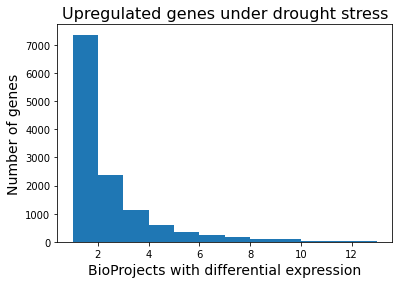

In [73]:
# now plot histograms
# start by plotting one for upregulated drought genes
plt.hist(histdfs["Up"]["Drought"]["GeneID"].value_counts(),
         bins=range(1,max(histdfs["Up"]["Drought"]["GeneID"].value_counts())+1,1))
plt.title("Upregulated genes under drought stress",fontsize=16)
plt.xlabel("BioProjects with differential expression",fontsize=14)
plt.ylabel("Number of genes",fontsize=14)
plt.savefig("../figures/pseudoDEGs_barplot_drought_up.pdf")

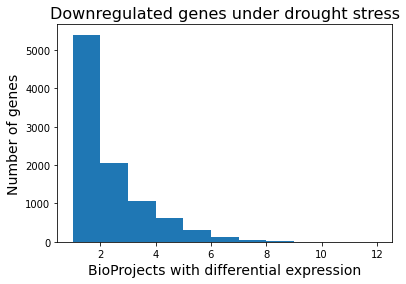

In [74]:
plt.hist(histdfs["Down"]["Drought"]["GeneID"].value_counts(),
         bins=range(1,max(histdfs["Down"]["Drought"]["GeneID"].value_counts())+1,1))
plt.title("Downregulated genes under drought stress",fontsize=16)
plt.xlabel("BioProjects with differential expression",fontsize=14)
plt.ylabel("Number of genes",fontsize=14)
plt.savefig("../figures/pseudoDEGs_barplot_drought_down.pdf")

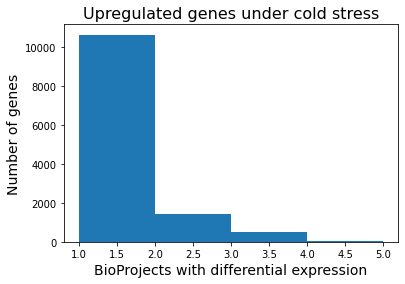

In [75]:
plt.hist(histdfs["Up"]["Cold"]["GeneID"].value_counts(),
         bins=range(1,max(histdfs["Up"]["Cold"]["GeneID"].value_counts())+1,1))
plt.title("Upregulated genes under cold stress",fontsize=16)
plt.xlabel("BioProjects with differential expression",fontsize=14)
plt.ylabel("Number of genes",fontsize=14)
plt.savefig("../figures/pseudoDEGs_barplot_cold_up.pdf")

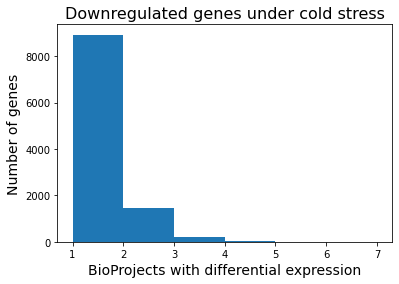

In [76]:
plt.hist(histdfs["Down"]["Cold"]["GeneID"].value_counts(),
         bins=range(1,max(histdfs["Down"]["Cold"]["GeneID"].value_counts())+1,1))
plt.title("Downregulated genes under cold stress",fontsize=16)
plt.xlabel("BioProjects with differential expression",fontsize=14)
plt.ylabel("Number of genes",fontsize=14)
plt.savefig("../figures/pseudoDEGs_barplot_cold_down.pdf")

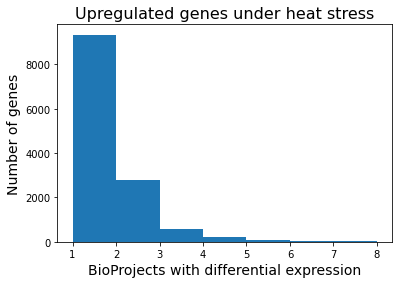

In [77]:
plt.hist(histdfs["Up"]["Heat"]["GeneID"].value_counts(),
         bins=range(1,max(histdfs["Up"]["Heat"]["GeneID"].value_counts())+1,1))
plt.title("Upregulated genes under heat stress",fontsize=16)
plt.xlabel("BioProjects with differential expression",fontsize=14)
plt.ylabel("Number of genes",fontsize=14)
plt.savefig("../figures/pseudoDEGs_barplot_heat_up.pdf")

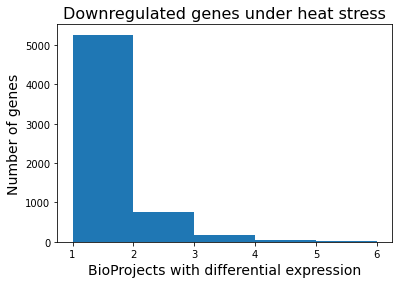

In [78]:
plt.hist(histdfs["Down"]["Heat"]["GeneID"].value_counts(),
         bins=range(1,max(histdfs["Down"]["Heat"]["GeneID"].value_counts())+1,1))
plt.title("Downregulated genes under heat stress",fontsize=16)
plt.xlabel("BioProjects with differential expression",fontsize=14)
plt.ylabel("Number of genes",fontsize=14)
plt.savefig("../figures/pseudoDEGs_barplot_heat_down.pdf")

## July 18, 2023: Find core stress gene sets

In [82]:
# for upgenes and downgenes: compress into dictionaries of sets by stressor, not by stressor then BioProject
newupgenes = {}
for s in upgenes.keys():
    d = upgenes[s]
    # make a set with the contents of the sets
    ## first make a list
    sgenes = []
    for k in d.keys():
        for i in d[k]:
            sgenes.append(i)
    newupgenes[s] = set(sgenes)

In [83]:
newupgenes

{'Cold': {'Zm00001eb343740',
  'Zm00001eb435710',
  'Zm00001eb005950',
  'Zm00001eb394410',
  'Zm00001eb039910',
  'Zm00001eb176600',
  'Zm00001eb122330',
  'Zm00001eb188630',
  'Zm00001eb365210',
  'Zm00001eb024800',
  'Zm00001eb187220',
  'Zm00001eb322010',
  'Zm00001eb269010',
  'Zm00001eb116960',
  'Zm00001eb174480',
  'Zm00001eb295120',
  'Zm00001eb111830',
  'Zm00001eb427560',
  'Zm00001eb386870',
  'Zm00001eb202460',
  'Zm00001eb349530',
  'Zm00001eb286560',
  'Zm00001eb153010',
  'Zm00001eb292600',
  'Zm00001eb435580',
  'Zm00001eb168430',
  'Zm00001eb291420',
  'Zm00001eb345980',
  'Zm00001eb212630',
  'Zm00001eb222830',
  'Zm00001eb354960',
  'Zm00001eb118470',
  'Zm00001eb172230',
  'Zm00001eb087120',
  'Zm00001eb145970',
  'Zm00001eb155950',
  'Zm00001eb335710',
  'Zm00001eb215270',
  'Zm00001eb346630',
  'Zm00001eb287780',
  'Zm00001eb074840',
  'Zm00001eb056450',
  'Zm00001eb244180',
  'Zm00001eb100200',
  'Zm00001eb229980',
  'Zm00001eb237050',
  'Zm00001eb203680',
  'Zm

In [84]:
# do the same for downregulated genes
newdowngenes = {}
for s in downgenes.keys():
    d = downgenes[s]
    # make a set with the contents of the sets
    ## first make a list
    sgenes = []
    for k in d.keys():
        for i in d[k]:
            sgenes.append(i)
    newdowngenes[s] = set(sgenes)

<AxesSubplot: >

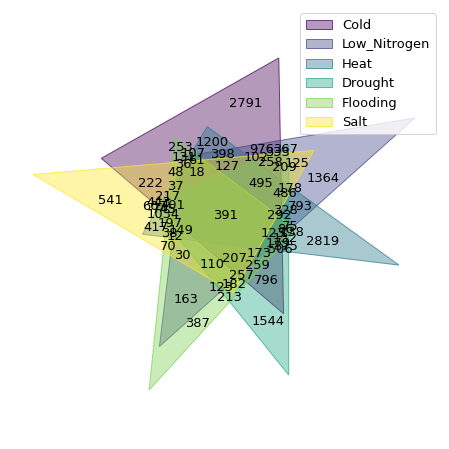

In [85]:
# make basic Venn diagrams of the up- and downregulated genes between stressors: upregulated first
venn(newupgenes)

<AxesSubplot: >

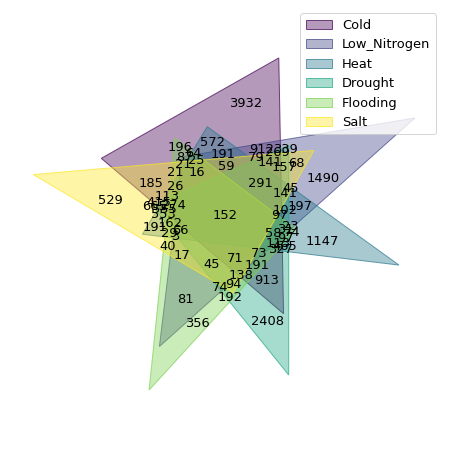

In [86]:
venn(newdowngenes)

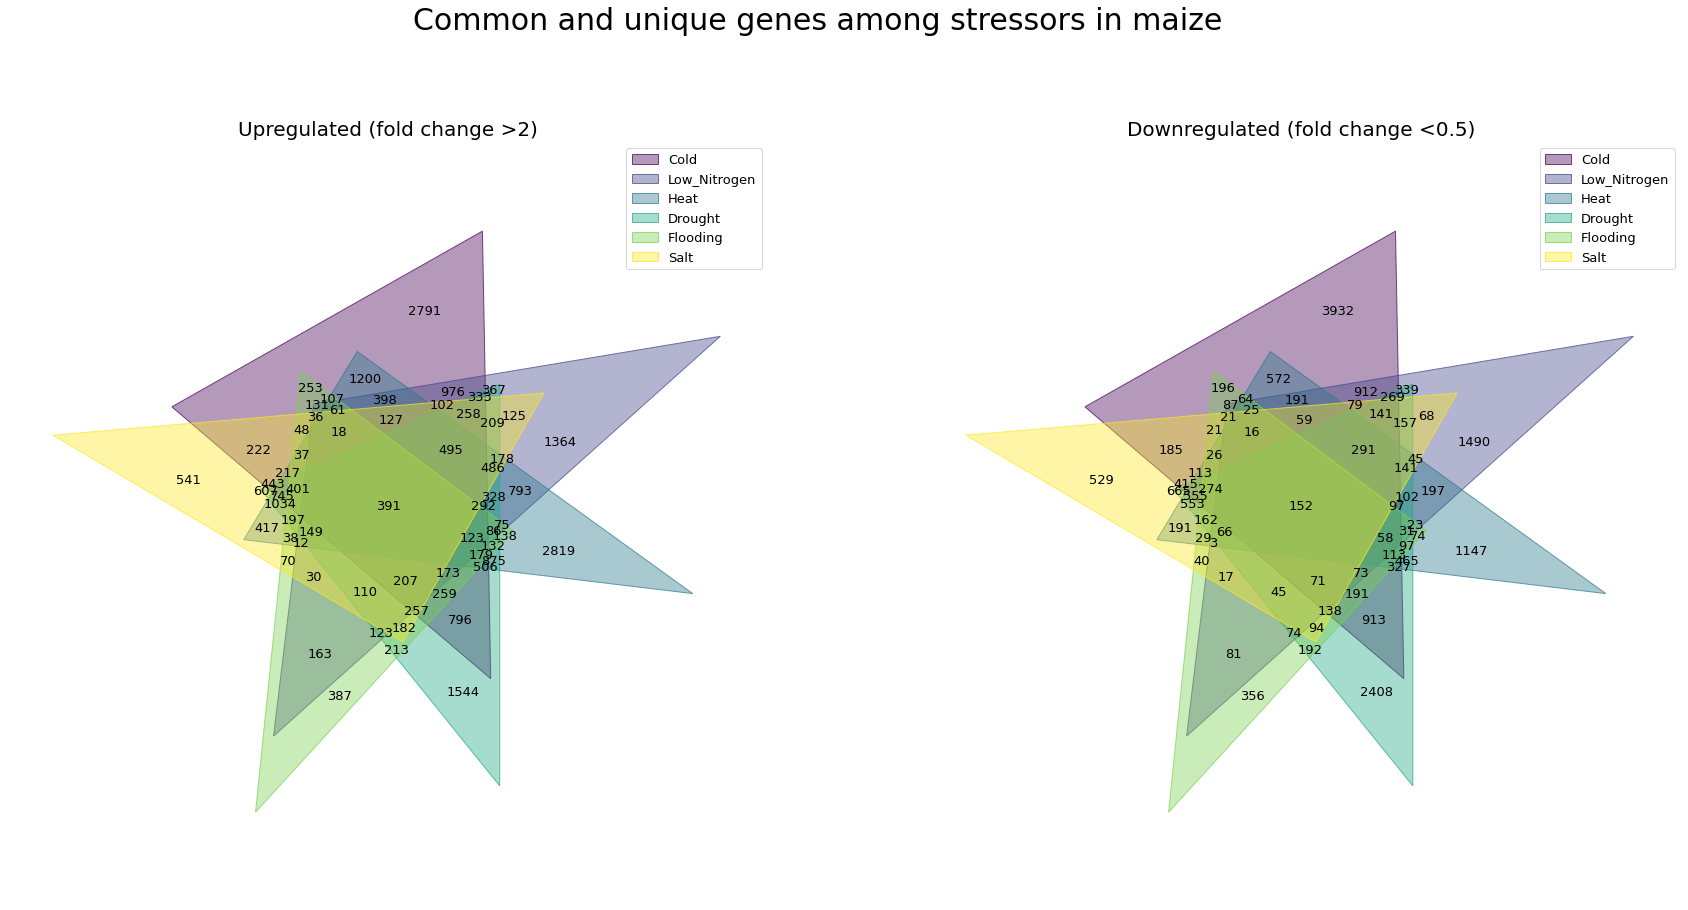

In [87]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,15))
a = venn(newupgenes,ax=ax[0])
a.set_title("Upregulated (fold change >2)",fontsize=20)
b=venn(newdowngenes,ax=ax[1])
b.set_title("Downregulated (fold change <0.5)",fontsize=20)
plt.suptitle("Common and unique genes among stressors in maize",fontsize=30)
plt.savefig("../figures/venn_stressors_tnratio.pdf")

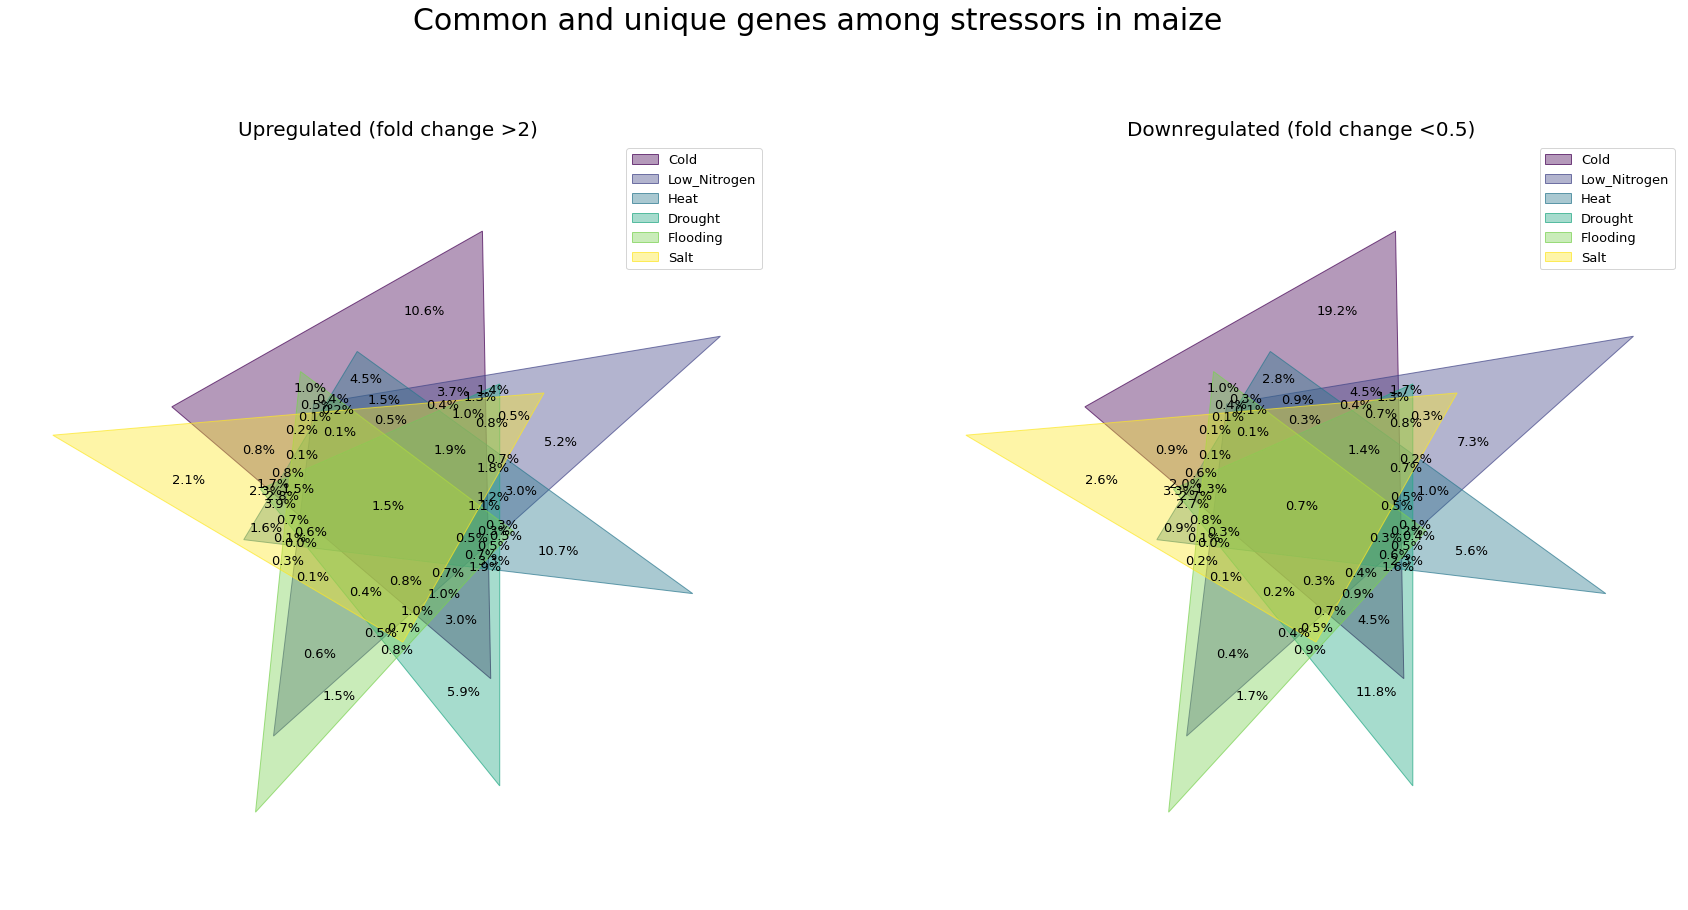

In [88]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,15))
a = venn(newupgenes,fmt="{percentage:.1f}%",ax=ax[0])
a.set_title("Upregulated (fold change >2)",fontsize=20)
b=venn(newdowngenes,fmt="{percentage:.1f}%",ax=ax[1])
b.set_title("Downregulated (fold change <0.5)",fontsize=20)
plt.suptitle("Common and unique genes among stressors in maize",fontsize=30)
plt.savefig("../figures/venn_stressors_tnratio_percent.pdf")

In [89]:
# save lists of the core genes
core_up = list(set.intersection(newupgenes["Cold"],newupgenes["Low_Nitrogen"],newupgenes["Heat"],newupgenes["Drought"],
                               newupgenes["Flooding"],newupgenes["Salt"]))
core_down = list(set.intersection(newdowngenes["Cold"],newdowngenes["Low_Nitrogen"],newdowngenes["Heat"],newdowngenes["Drought"],
                               newdowngenes["Flooding"],newdowngenes["Salt"]))

In [90]:
# save as text files
with open("../data/core_upgenes_fromsets.txt","w+") as outfile:
    for i in core_up:
        outfile.write(i+"\n")

In [91]:
with open("../data/core_downgenes_fromsets.txt","w+") as outfile:
    for i in core_down:
        outfile.write(i+"\n")

In [92]:
newupgenes

{'Cold': {'Zm00001eb343740',
  'Zm00001eb435710',
  'Zm00001eb005950',
  'Zm00001eb394410',
  'Zm00001eb039910',
  'Zm00001eb176600',
  'Zm00001eb122330',
  'Zm00001eb188630',
  'Zm00001eb365210',
  'Zm00001eb024800',
  'Zm00001eb187220',
  'Zm00001eb322010',
  'Zm00001eb269010',
  'Zm00001eb116960',
  'Zm00001eb174480',
  'Zm00001eb295120',
  'Zm00001eb111830',
  'Zm00001eb427560',
  'Zm00001eb386870',
  'Zm00001eb202460',
  'Zm00001eb349530',
  'Zm00001eb286560',
  'Zm00001eb153010',
  'Zm00001eb292600',
  'Zm00001eb435580',
  'Zm00001eb168430',
  'Zm00001eb291420',
  'Zm00001eb345980',
  'Zm00001eb212630',
  'Zm00001eb222830',
  'Zm00001eb354960',
  'Zm00001eb118470',
  'Zm00001eb172230',
  'Zm00001eb087120',
  'Zm00001eb145970',
  'Zm00001eb155950',
  'Zm00001eb335710',
  'Zm00001eb215270',
  'Zm00001eb346630',
  'Zm00001eb287780',
  'Zm00001eb074840',
  'Zm00001eb056450',
  'Zm00001eb244180',
  'Zm00001eb100200',
  'Zm00001eb229980',
  'Zm00001eb237050',
  'Zm00001eb203680',
  'Zm

In [93]:
# save JSON files with the upregulated and downregulated genes that are unique to each stressor
## first make a dictionary of lists of upregulated genes
up_unique_genes = {}
for s in newupgenes.keys():
    keys = list(newupgenes.keys())
    keys.remove(s)
    geneset = newupgenes[s].difference(newupgenes[keys[0]],newupgenes[keys[1]],newupgenes[keys[2]],newupgenes[keys[3]],
                                      newupgenes[keys[4]])
    up_unique_genes[s] = list(geneset)

In [96]:
# do the same for unique downregulated genes
down_unique_genes = {}
for s in newdowngenes.keys():
    keys = list(newdowngenes.keys())
    keys.remove(s)
    geneset = newdowngenes[s].difference(newdowngenes[keys[0]],newdowngenes[keys[1]],newdowngenes[keys[2]],newdowngenes[keys[3]],
                                      newdowngenes[keys[4]])
    down_unique_genes[s] = list(geneset)

In [98]:
import json

In [101]:
# save to json files
with open("../data/peripheral_response_upgenes_fromsets.json","w+") as outfile:
    json.dump(up_unique_genes,outfile,indent=4)

In [102]:
with open("../data/peripheral_response_downgenes_fromsets.json","w+") as outfile:
    json.dump(down_unique_genes,outfile,indent=4)